In [1]:
import pandas as pd
import os
import mne
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
from mne.stats import permutation_cluster_1samp_test

In [2]:
cwd = os.getcwd()
root = 'D:/EEG_wd/Machine_learning/'
names = os.listdir(root + 'TNT/1_raw')  # Subjects ID
names = sorted(list(set([subject[:5] for subject in Names])))

NameError: name 'Names' is not defined

# Behavioral results

## Attention

Extract response time

In [ ]:
# Extract behavioral results
behavior_df = pd.DataFrame([])
for subject in Names:

    attention_df = pd.read_csv(root + 'Attention/Behavior/' + subject + '.txt')

    for cond in ['Baseline', 'No-Think', 'Think']:

        for block in np.arange(1, 9):

            rt = attention_df['Image.RT'][(attention_df.Cond1 == cond) & 
                                          (attention_df['ListImage.Cycle'] == block)].mean()

            behavior_df = behavior_df.append(pd.DataFrame({'Subject': subject,
                                                           'Block' : block,
                                                           'Condition': cond,
                                                           'TR': rt}, index=[0]), ignore_index=True, sort=True)

behavior_df.TR = behavior_df.TR/1000 # Convert to seconds

In [ ]:
plt.rcParams['figure.figsize'] = [6.0, 6.0]
sns.set_context("poster", font_scale=1.2)

sns.lineplot(data=behavior_df,
             x="Block",
             y="TR",
             hue="Condition",
             style="Condition",
             markers=True,
             legend=False,
             dashes=False,
             palette=['#9a5b88',
                      sns.xkcd_rgb["pale red"],
                      sns.xkcd_rgb["medium green"]])
plt.title('Attention task performances', fontweight="bold")
plt.xlabel('Experimental blocks')
plt.ylabel('Response Time (s)')
plt.xticks(np.arange(2, 9, 2))
sns.despine(offset=10, trim=True)
plt.savefig(cwd + '/Figures/Attention_RT.svg', dpi=300, bbox_inches='tight')

Run RM ANOVA

In [ ]:
behavior_df.rm_anova(dv='TR',
                     within=['Condition', 'Block'],
                     subject='Subject',
                     detailed=True)

Posthoc - Conditions

In [ ]:
behavior_df.pairwise_ttests(dv='TR', 
                            within='Condition', 
                            subject='Subject',
                            padjust='bonferroni',
                            effsize='cohen')

Save for validation with JASP

In [ ]:
a = behavior_df.pivot_table(columns = ['Condition', 'Block'], values = 'TR', index = 'Subject')
a.to_csv('Results/Attention.txt')

## Think/No-Think

Read recall df

In [3]:
recall = pd.read_csv(cwd + '/Results/Recall.txt', sep='\t')
recall = recall.groupby(['nSub', 'Condition'], as_index=False).mean()

(array([0, 1, 2]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

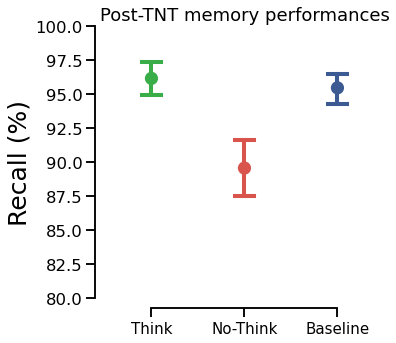

In [4]:
sns.set_context("talk")
plt.figure(figsize=(5, 5))
sns.pointplot(data=recall, x="Condition", y="freq", capsize=0.2,
            dodge=0.1, ci=68, legend=True, legend_out=False,
            order=['Think', 'No-Think', 'Baseline'],
            palette=[sns.xkcd_rgb["medium green"],
                     sns.xkcd_rgb["pale red"],
                     sns.xkcd_rgb["denim blue"]])

plt.ylim([80, 100])
sns.despine(offset=10, trim=True)
plt.ylabel('Recall (%)', size=25)
plt.xlabel('')
plt.title('Post-TNT memory performances')
plt.xticks(size=15)
#plt.savefig(cwd + '/Figures/Recall.svg', dpi=300, bbox_inches='tight')

RM ANOVA

In [5]:
recall.rm_anova(dv='freq', within='Condition', subject='nSub')

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Condition,2,46,15.968153,0.000005,0.00011,0.409774,0.675722,False,0.520102,0.000753


Posthoc

In [6]:
recall.pairwise_ttests(dv='freq',
                       within='Condition',
                       subject='nSub',
                       padjust='bonferroni',
                       effsize='cohen')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,Condition,Baseline,No-Think,True,True,3.679358,23.0,two-sided,0.001243,0.003728,bonferroni,28.996,0.712541
1,Condition,Baseline,Think,True,True,-0.890564,23.0,two-sided,0.382385,1.000000,bonferroni,0.307,-0.119375
2,Condition,No-Think,Think,True,True,-4.978461,23.0,two-sided,0.000049,0.000148,bonferroni,512.179,-0.792025


Save for validation with JASP

In [7]:
a = recall.pivot_table(columns=['Condition'], values='freq', index='nSub')
a.to_csv('Results/TNT.txt')

# Decoding attention task

Extract the average decoding scores outputed by `5_attention_decoding.py`

In [8]:
scores = np.load(root + 'Attention_decoding.npy')

Using a threshold of 2.055529
stat_fun(H1): min=-1.698697 max=12.540136
Running initial clustering
Found 17 clusters
Permuting 4999 times...


<ipython-input-9-26d978281942>:10: DeprecationWarning: The default for "out_type" will change from "mask" to "indices" in version 0.22. To avoid this warning, explicitly set "out_type" to one of its string values.
  n_jobs=1)



Computing cluster p-values
Done.


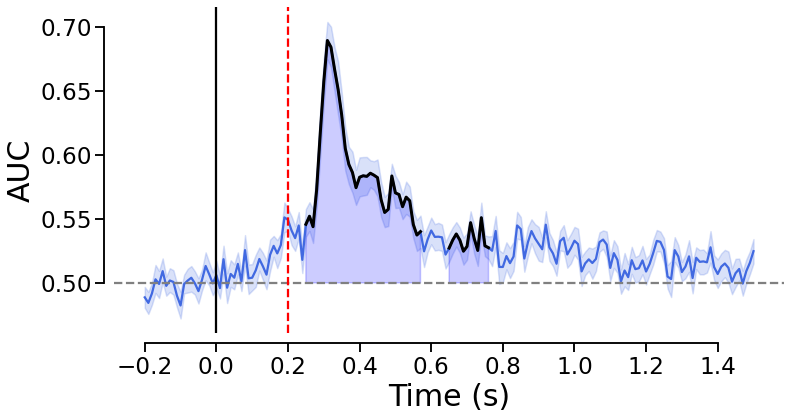

In [9]:
df = pd.DataFrame(scores).melt()
df['Time'] = (df.variable / 100) - 0.2

# Permutation 1 sample
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_1samp_test(scores - 0.5,
                                   threshold=None,
                                   n_permutations=5000,
                                   tail=0,
                                   n_jobs=1)

# Create new stats image with only significant clusters
T_obs_plot = np.nan * np.ones_like(T_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.01:
        T_obs_plot[c] = T_obs[c]

# Plot scores
plt.rcParams['figure.figsize'] = [12, 6]
sns.set_context("talk", font_scale=1.4)
sns.lineplot(x="Time", y="value", 
             data=df, 
             ci=68, 
             color='royalblue')
plt.axhline(y=0.5, linestyle='--', color='gray')
plt.axvline(x=0.2, color='red', linestyle='--')
plt.axvline(x=0., color = 'k')
plt.ylabel('AUC', size=30)
plt.xlabel('Time (s)', size=30)
plt.xticks(np.arange(-0.2, 1.5, 0.2))

# plot significant time range
plt.fill_between(np.arange(-0.2, 1.51, 0.01),0.5,
                 scores.mean(0), where = ~np.isnan(T_obs_plot),
                 color='b', alpha=0.2)

mask = np.ma.masked_where(np.isnan(T_obs_plot), scores.mean(0))

plt.plot(np.arange(-0.2, 1.51, 0.01),
         mask,
         color='k',
         linewidth = 3)
sns.despine(offset=10, trim=True)
plt.savefig('attention_decoding.svg', dpi=300)

# Mental events

Extract the number of mentals events in intrusive trials outputed by `9_mental_events.py`

In [10]:
events_df = pd.read_csv(root + 'Results/Decoding/mental_events.txt')

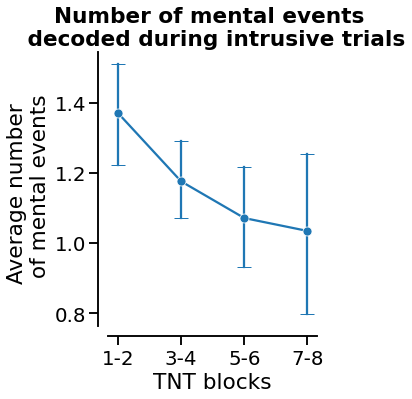

In [11]:
plt.rcParams['figure.figsize'] = [5.0, 6.0]
sns.set_context("talk", font_scale=1.2)
plt.title('Number of mental events \n decoded during intrusive trials', fontweight="bold")
sns.lineplot(data=events_df,
              x='Block',
              y='Events',
              err_style='bars',
              marker="o",
              ci=68,
              err_kws={'capsize':7})
plt.ylabel('Average number \n of mental events')
plt.xlabel('TNT blocks')
sns.despine(offset=10)
plt.tight_layout()
plt.savefig(cwd + '/Figures/mental_events.svg', dpi=300)

In [12]:
events_df.rm_anova(dv='Events', within='Block', subject='Subject')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,Block,3,72,10.451909,0.000009,0.303377,0.58773


# Time-frequency

Load eeg example file

In [13]:
path = root + 'TNT/5_autoreject/31NLI-epo.fif'
tnt = mne.read_epochs(path, preload=True)
tnt.pick_types(emg=False, eeg=True, stim=False, eog=False, misc=False, exclude='bads')

Reading D:/EEG_wd/Machine_learning/TNT/5_autoreject/31NLI-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    4000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
381 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


<EpochsFIF |  381 events (all good), -1.5 - 4 sec, baseline [-1.5, 0], ~1.59 GB, data loaded,
 'No-Think/EMO': 96
 'No-Think/NEU': 95
 'Think/EMO': 95
 'Think/NEU': 95>

Extract the time-frequency representation outputed by `11_time_locked_TF.py`

In [18]:
intrusion, baseline=[], []
for subject in names:
    try:
        intrusion.append(np.load(root + '/Results/Time-locked/' + subject[:5] + '_TimeLockedIntrusion_TF.npy'))
        baseline.append(np.load(root + '/Results/Time-locked/' + subject[:5] + '_TimeLockedBaseline_TF.npy'))
        
    except:
        print(subject + ' without TFR') # Not enought decoded intrusions

# Create evoked object
this_tfr = mne.time_frequency.EpochsTFR(info=tnt.info, 
                                        data=np.asarray(intrusion) - np.asarray(baseline),
                                        times=np.arange(-0.2, 0.8, 0.01),
                                        freqs=np.arange(3, 30))

41BAL-raw.fif without TFR
57NCO-raw.fif without TFR
Not setting metadata


Using a threshold of 2.063899
stat_fun(H1): min=-3.500210 max=2.896839
Running initial clustering
Found 9 clusters
Permuting 4999 times...


<ipython-input-19-46b49ca1c51f>:7: DeprecationWarning: The default for "out_type" will change from "mask" to "indices" in version 0.22. To avoid this warning, explicitly set "out_type" to one of its string values.
  threshold=threshold, tail=0)



Computing cluster p-values
Done.


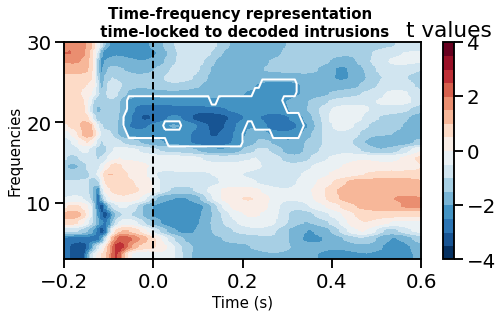

In [19]:
def tfr_permutation(data):

    threshold = None
    n_permutations = 5000
    T_obs, clusters, cluster_p_values, H0 = \
        permutation_cluster_1samp_test(data, n_permutations=n_permutations,
                                       threshold=threshold, tail=0)
            
    # Create new stats image with only significant clusters
    T_obs_plot = np.nan * np.ones_like(T_obs)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= 0.05:
            T_obs_plot[c] = T_obs[c]
    
    
    plt.figure(figsize=(8, 4))
    plt.imshow(T_obs, cmap=plt.cm.get_cmap('RdBu_r', 16), vmin=-4, vmax=4,
               extent=[-0.2, 0.6, 3, 30], aspect='auto', origin='lower', interpolation='hanning')
    clb = plt.colorbar()
    clb.ax.set_title('t values')
    plt.contour(~np.isnan(T_obs_plot), colors=["w"], extent=[-0.2, 0.6, 3, 30],
                linewidths=[2], corner_mask=False, antialiased=True, levels=[.5])
    plt.axvline(x=0, linestyle='--', linewidth=2, color='k')
    plt.title('Time-frequency representation \n time-locked to decoded intrusions', size=15, fontweight='bold')
    plt.ylabel('Frequencies', size=15)
    plt.xlabel('Time (s)', size=15)
    plt.savefig(cwd + '/Figures/Time-locked_TFR.svg', dpi=300)
    
    return T_obs_plot

data = this_tfr._data.mean(1) # Average over channels

T_obs_plot = tfr_permutation(data)